<a href="https://colab.research.google.com/github/tyro2001/hello-world/blob/master/ML1_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

**Problem 1**

In [2]:
NUM_DRAWS = 1_000

draws = ss.expon.rvs(size=NUM_DRAWS)
results = {'MSE': dict(), "MAE" : dict()}
estimators = {'Mean  ': 1.0, 'Median': math.log(2)}

for name, y_hat in estimators.items():
    residuals = draws - y_hat
    rss = np.sum(np.power(residuals, 2))
    rsa = np.sum(np.abs(residuals))
    results['MSE'][name] = rss / NUM_DRAWS
    results['MAE'][name] = rsa / NUM_DRAWS

for measure in results:
    for name, result in results[measure].items():
        print(measure, name, round(result, 6))
    print()




MSE Mean   0.88672
MSE Median 0.957584

MAE Mean   0.698681
MAE Median 0.65289



The mean works better for mean squared error (MSE), but the median is better for mean absolute error (MAE). 

**Problem 2**

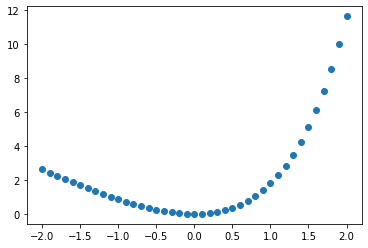

In [3]:
def loss(a, b, z):
    assert(a > 0)
    assert(b > 0)
    return b * (math.exp(a*z) - a*z - 1)

def part_a():
    a = 1.1  ## given
    b = 2.0  ## given
    step = .1
    loss_vec = list()
    z_vec = np.arange(-2, 2 + step, step)
    for z in z_vec:
        loss_vec.append(loss(a, b, z))

    plt.scatter(z_vec, loss_vec)
    plt.show()

part_a()

This loss function penalizes positive errors more than negative ones.  You might prefer this when overshooting would result in breaking a regulatory limit and a financial penalty.

Part (b)


Use the iterated condintioning from class:


$E \left[ E \left[b\left(e^{a(Y-\mu(x))} - a(Y-\mu(x)) - 1\right)| X=x \right] \right]$


Since we are going to minimize with respect to $\mu(x)$ and $b>0$, I am just going to remove $b$.  I will also distribute the $a$


$E \left[ E \left[e^{aY} e^{-a\mu(x)} - aY + a\mu(x) - 1| X=x \right] \right]$


Now let's distribute the inner conditional expectation by making use of the fact that $E\left[\mu(x) | X=x \right] = \mu(x)$:


$E \left[e^{-a\mu(x)} E \left[e^{aY}| X = x \right]  - a E \left[ Y|X=x \right] + a\mu(x) - 1 \right ]$


Focus on the terms that rely on $\mu(x)\$:

$e^{-a\mu(x)} E \left[e^{aY}| X = x \right]  + a\mu(x)$


Let $ c = E \left[e^{aY}| X = x \right] $ and $ z = \mu(x)$ and minimize the following:

$f(z) = c e^{-az} + az$

$f^{'}(z) = -ca e^{-az} + a$

$f^{''}(z) = ca^2 e^{-az} > 0$ since c is the conditional expectation of an exponential


Set the first derivative equal to zero to get:

$ca e^{-az} = a => e^{-az} = c^{-1} => -az = -\log{c} => z = \frac{\log{c}}{a}$


Rewrite in the original terms:

$\mu(x) = \frac{\log{(E \left[e^{aY}| X = x \right])}}{a}$

Part (c)

Using the equation from the moment generating function in the problem description we have:


$ E \left[e^{aY}| X = x \right] = e^{\beta x a+ \frac{1}{2}\sigma^2 a^2}$

Using the equation from part (b) we have:

$\mu(x) = \frac{\beta x a+ \frac{1}{2}\sigma^2 a^2}{a} = \beta x + \frac{1}{2}\sigma^2 a$

Part (d)

I made the following change to asymm_loss.py:

In [4]:
def f_yours(x):
    return beta*x + .5 * sigma**2 * a

and got the following results:

Average loss of the conditional expectation: 15.69  
Average loss of your method: 4.41

I have a lower average loss because conditional mean is optimal for a squared error loss function.  Mine is the optimal one for the loss function described in this exercise - see the minimization in part (c).  This shouldn't be suprising b/c the loss function has asymmetric penalties as illusrated in the plot above.  



**Problem 3**

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


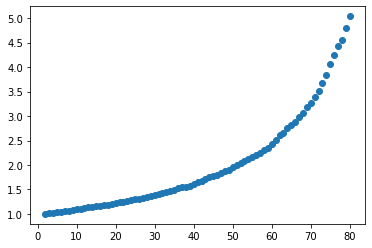

In [5]:
import statsmodels.api as sm

MAX_P = 80
NUM_ITERS = 100
NUM_POINTS = 100

## using beta on epsilon is a little
## bit of an abuse of common naming.
## just makes it eaiser.  
true_beta = np.zeros(MAX_P+1)
true_beta[0] = 1.0  ## epsilon
true_beta[1] = 4.0  ## X_1

mse_sums = np.zeros(MAX_P+1)
for i in range(NUM_ITERS):
    ## column zero will be the epsilons initially
    train_data = ss.norm.rvs(size = [NUM_POINTS, MAX_P+1])
    test_data  = ss.norm.rvs(size = [NUM_POINTS, MAX_P+1])
    train_y = train_data @ true_beta
    test_y  = test_data  @ true_beta

    ## now let's make column zero equal to 1.0
    ## for the intercept
    train_data[:, 0] = 1.0
    test_data[:, 0] = 1.0

    for n in range(2, MAX_P+1):
        mod = sm.OLS(train_y, train_data[:, 0:n])
        res = mod.fit()
        test_y_hat = test_data[:, 0:n] @ res.params
        mse = np.mean(np.power(test_y - test_y_hat, 2))
        mse_sums[n] += mse

mse_avg = mse_sums / NUM_ITERS
plt.scatter(range(2, MAX_P+1), mse_avg[2:])
plt.show()


I see the size of the average MSE of the test data blowing up with the number of parameters.  